In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.nn import Conv2d

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)


C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#train_data = torch.FloatTensor(train_data).cuda()

In [4]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory= True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, pin_memory= True)


In [5]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
    
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)
x.device

torch.Size([1, 1, 28, 28])


device(type='cpu')

In [6]:
model = torchvision.models.resnet18(num_classes=10).cuda()
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
model.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.cuda(), y_train.cuda()
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.00015901  accuracy:  99.100%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.01906411  accuracy:  99.095%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00317940  accuracy:  99.080%
epoch:  0  batch: 4000 [ 40000/60000]  loss: 0.00388355  accuracy:  99.062%
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.00025031  accuracy:  99.084%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00001310  accuracy:  99.087%
epoch:  1  batch: 1000 [ 10000/60000]  loss: 0.00095018  accuracy:  99.330%
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.00023941  accuracy:  99.275%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.00063006  accuracy:  99.290%
epoch:  1  batch: 4000 [ 40000/60000]  loss: 0.00044727  accuracy:  99.267%
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.00143224  accuracy:  99.280%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 0.00104024  accuracy:  99.225%
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.00193962  accuracy:  99.420%
epoch:  2  b

In [71]:
test_losses_item = []
for i in test_losses:
    print(i)
    test_losses_item.append(i.item())
test_losses_item

tensor(4.1696e-05, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(1.5532e-05, device='cuda:0')
tensor(0.0001, device='cuda:0')


[4.169609019299969e-05,
 0.0011651801178231835,
 0.0039052150677889585,
 1.5532103134319186e-05,
 0.00011111652565887198]

[1.3100907381158322e-05, 0.001040240633301437, 0.0643627792596817, 8.320645065396093e-06, 0.002336058532819152]
[tensor(4.1696e-05, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(1.5532e-05, device='cuda:0'), tensor(0.0001, device='cuda:0')]


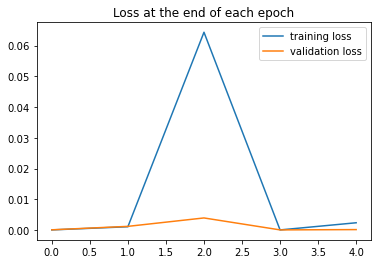

In [46]:
print(train_losses)
print(test_losses)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses_item, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [70]:
test_correct_item = []
for i in test_correct:
    print(i.item())
    test_correct_item.append(i.item())
test_correct_item

9925
9928
9913
9923
9921


[9925, 9928, 9913, 9923, 9921]

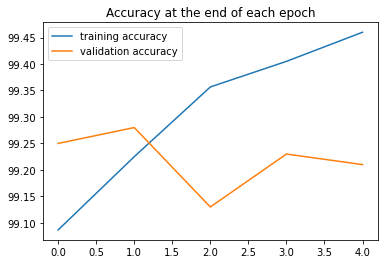

In [69]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct_item], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [58]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [59]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.cuda(), y_test.cuda()
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9921/10000 =  99.210%


In [60]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

79

In [62]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

True
Index: tensor([ 115,  175,  326,  340,  445,  625,  646,  659,  674,  846,  947, 1014],
       device='cuda:0')
Label: tensor([4, 7, 2, 5, 6, 6, 2, 2, 5, 7, 8, 6], device='cuda:0')
Guess: tensor([9, 1, 1, 3, 0, 4, 1, 1, 3, 9, 9, 0], device='cuda:0')


C:\Users\enriq\AppData\Local\Temp/ipykernel_20712/2165462237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_20712/2165462237.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_20712/2165462237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = X_test.index_select(0,torch.tensor(nextrow))


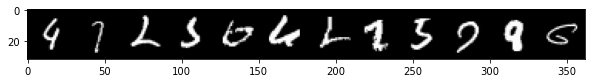

In [63]:
nextrow = next(row)
nextrow = torch.from_numpy(nextrow).to(device)
print(nextrow.is_cuda)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.cpu().numpy(), (1, 2, 0)));

True


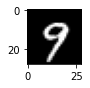

In [66]:
x = 5050
x = torch.tensor(x).cuda()
print(x.is_cuda)
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gray");

In [67]:
model.eval()
with torch.no_grad():
    new_pred = model(X_test[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
